In [1]:
from openai import OpenAI
import numpy as np
import time
import requests
import random

def flush():
    requests.post("http://localhost:30000/flush_cache")

# SG Lang server address
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:30000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

flush()

def timed_completion(prompt):
    start_time = time.perf_counter()
    completion = client.completions.create(model="TheBloke/Llama-2-7B-GPTQ", #"facebook/opt-125m",
                prompt=prompt, temperature=.7, max_tokens=1)
    end_time = time.perf_counter()
    return completion.choices[0].text, (end_time - start_time)*1000


In [2]:
N = 1000
miss_times = []
hit_times = []
is_flushed = True
for _ in range(N):
    # if random.random() < .5:
    #     flush()
    #     is_flushed = True
    flush()
    _, _ = timed_completion("Python is a programming language that developer across the world use to ")
    _, hit_time_ms = timed_completion("Python is a programming language that")
    _, miss_time_ms = timed_completion("Blue was a programming language that")
    miss_times.append(miss_time_ms)
    hit_times.append(hit_time_ms)
    # if is_flushed:
    #     miss_times.append(time_ms)
    # else:
    #     hit_times.append(time_ms)
    # is_flushed = False
miss_times = np.array(miss_times)
hit_times = np.array(hit_times)
print(f"{len(hit_times)} hits, {len(miss_times)} misses")
print(f"Average time w/flush: \t\t{np.mean(miss_times)} ms, sigma: {np.sqrt(np.var(miss_times))}")
print(f"Average time: \t\t\t{np.mean(hit_times)} ms, sigma: {np.sqrt(np.var(hit_times))}")
    

1000 hits, 1000 misses
Average time w/flush: 		16.350626294966787 ms, sigma: 3.7527903686252038
Average time: 			16.049388939514756 ms, sigma: 3.7038838318451015


# ROC Without Network Noise Added

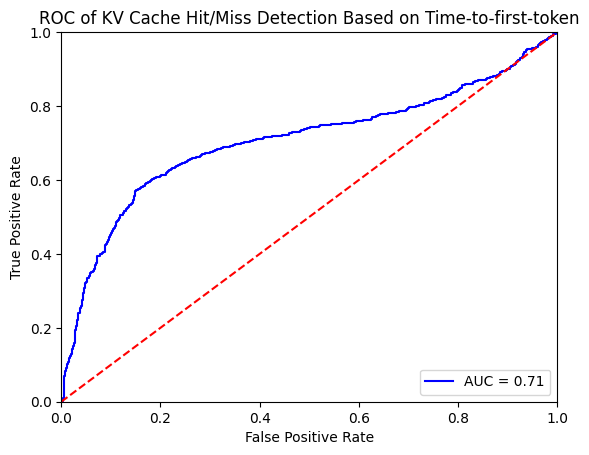

In [3]:
from sklearn.linear_model import *
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

X = np.concatenate((miss_times, hit_times)).reshape(-1, 1)
y = np.concatenate((np.zeros_like(miss_times), np.ones_like(hit_times)))
clf = LogisticRegression().fit(X, y)

# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC of KV Cache Hit/Miss Detection Based on Time-to-first-token')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ROC With Network Noise Added

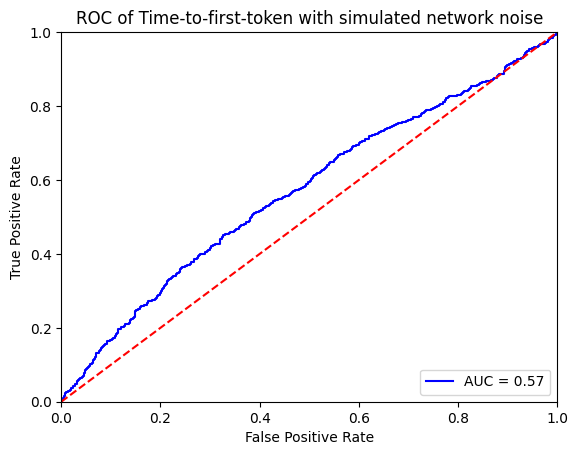

In [4]:
from sklearn.linear_model import *
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

X = np.concatenate((miss_times, hit_times)).reshape(-1, 1)
noise = np.random.normal(0, .81, X.shape)
X += noise
y = np.concatenate((np.zeros_like(miss_times), np.ones_like(hit_times)))
clf = LogisticRegression().fit(X, y)

# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC of Time-to-first-token with simulated network noise')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [5]:
import subprocess
import re
import numpy as np
import matplotlib.pyplot as plt

def ping_n(host, n):
    response_times = []
    for _ in range(n):
        # Run the ping command
        try:
            result = subprocess.run(
                ["ping", "-c", "1", host],  # Use "-n" instead of "-c" on Windows
                capture_output=True,
                text=True
            )
            # Extract the time in ms using a regex
            match = re.search(r"time=(\d+\.?\d*) ms", result.stdout)  # Use "time=(\d+\.?\d*)ms" on Windows
            if match:
                response_times.append(float(match.group(1)))
            else:
                response_times.append(None)  # Append None if no response time is found
        except Exception as e:
            response_times.append(None)  # Handle errors gracefully

    return response_times

# Example usage
host = "chatgpt.com"
n = 1000
times = ping_n(host, n)
times = [t for t in times if t < 10] # remove outliers
times = np.array(times)

mean = np.mean(times)
sigma = np.sqrt(np.var(times))
print(f"Mean: {mean}, Sigma: {sigma}")


Mean: 5.56056968463886, Sigma: 0.871085711256149


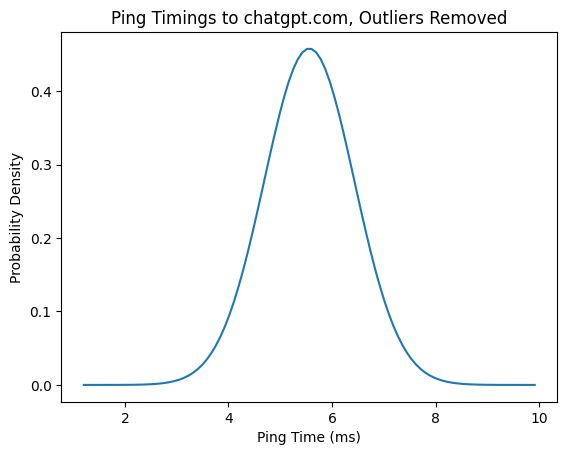

In [6]:
from scipy.stats import norm
x = np.linspace(mean - 5*sigma, mean + 5*sigma, 100)
y = norm.pdf(x, mean, sigma)

# Plot the data
plt.plot(x, y, label=f'Mean: {mean}, Std Dev: {sigma}')
plt.title("Ping Timings to chatgpt.com, Outliers Removed")
plt.xlabel("Ping Time (ms)")
plt.ylabel("Probability Density")
plt.show()